<a href="https://colab.research.google.com/github/a-donat/Data-Science-Portfolio/blob/master/Analyzing_Culinary_of_Foods_Similarities_w_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing Culinary Similarities Between Foods with Natural Language Processing (NLP)

by Annalisa Donat

## Overview
In this project, I will create an .html file containing an interactive visualization of the culinary similarities between foods. More similar foods will appear closer together.

**Defining "similar foods"**: I will consider two foods to be similar if they are often used in similar recipes (ex. blueberries and raspberries are often used in fruit salads, pies, and yogurt, thus blueberries and raspberries will be considered similar).

**The math behind visualizing similarity**: I will compute the cosine similarity matrix of vectors in a table (computed with Gensim) in which each vector represents whether a given ingredient appeared in the listed recipes. I will then use the the NetworkX library to implement the Fruchterman-Reingold force-directed algorithm to compute the optimal position on the graph for each food.

**Main libraries and how I will use them**:
*   Gensim – Use Natural Language Processing (NLP) to creates ingredients vs recipes table.
*   Networkx – Compute positions of ingredients in similarity graph
* Plotly – Create interactive data visualization

Note: Some recipes included in this analysis can be considered ingredients or components of other recipes (ex. there may be a recipe for strawberry jam, and a recipe for a cake with a strawberry jam filling).


## Contents
- Part 1: Introduction
- Part 2: Load Libraries and Dataset
- Part 3: Preprocess the Data
- Part 4: Word2Vec with Gensim
- Part 5: Explore Results
- Part 6: Build and VisualizeInteractive Network Graph

## Part 1: Introduction
We will be using a recipe dataset, to train a model to learn the interactions between different kind of ingredients and available products in a supermarket. This model can then be implemented in a number of different ways, for example,
- to recommend products based on items added to cart;
- to offer alternatives products based on stock;
- to discover new products to create different recipes.


### Recipe Sample
*Herb Rubbed Sirloin Tip Roast*

- 1 1/4 tablespoons paprika
- 1 tablespoon kosher salt
- 1 teaspoon garlic powder
- 1/2 teaspoon ground black pepper
- 1/2 teaspoon onion powder
- 1/2 teaspoon ground cayenne pepper
- 1/2 teaspoon dried oregano
- 1/2 teaspoon dried thyme
- 2 tablespoons olive oil
- 1 (3 pound) sirloin tip roast

In a small bowl, mix the paprika, kosher salt, garlic powder, black pepper, onion powder, cayenne pepper, oregano, and thyme. Stir in the olive oil, and allow the mixture to sit about 15 minutes.

Preheat oven to 350 degrees F (175 degrees C). Line a baking sheet with aluminum foil.

Place the roast on the prepared baking sheet, and cover on all sides with the spice mixture.

Roast 1 hour in the preheated oven, or to a minimum internal temperature of 145 degrees F (63 degrees C). Let sit 15 minutes before slicing.


## Part 2: Load Libraries and Dataset

In [1]:
from gensim.parsing.preprocessing import remove_stopwords
from tqdm import tqdm
import pandas as pd
import pickle
import string
import json

In [35]:
from gensim.models.word2vec import Word2Vec

In [70]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#matplotlib.rcParams['figure.dpi'] = 800
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [15]:
from typing import *

In [55]:
from sklearn.metrics.pairwise import cosine_similarity
import plotly.graph_objects as go
from plotly.offline import plot
import networkx as nx
import numpy as np

In [58]:
import random
random.seed(3)

In [2]:
recipe_sources = ['ar', 'epi', 'fn']

[Dataset](https://eightportions.com/datasets/Recipes/#fn:1) is collated by Ryan Lee, and sourced from [Food Network](https://www.foodnetwork.com/), [Epicurious](https://www.epicurious.com/), and [Allrecipes](https://www.allrecipes.com/).

In [8]:
sources, titles, ingredients, instructions = [], [], [], []
for recipe_source in recipe_sources:
    data = json.load(
        open('/content/recipes_raw_nosource_%s.json' % recipe_source, 'r'))
    for idstr, recipe in data.items():
        if ('title' in recipe) and ('ingredients' in recipe) and (
            'instructions' in recipe):
            # append to a list of the source
            sources.append(recipe_source)
            # append to a list of the titles (note that recipe is a dictionary)
            titles.append(recipe["title"])
            # append to a list of a list of ingredients, removing the word ADVERTISEMENT
            ingredients.append(
                [ingredient.replace(" ADVERTISEMENT", "") 
                for ingredient in recipe["ingredients"]])
            # append to a silst of instructions, remmoving the word ADVERTISEMENT and replace \n with space characters
            instructions.append(
                str(recipe["instructions"]).replace(
                    " ADVERTISEMENT", "").replace("\n", " "))
df = pd.DataFrame.from_dict(
    {"source": sources, "title": titles, "ingredients": ingredients, 
     "instructions": instructions})


## Part 3: Preprocess Data

In [9]:
df.head()

,source,title,ingredients,instructions
0,ar,Slow Cooker Chicken and Dumplings,"[4 skinless, boneless chicken breast halves, 2...","Place the chicken, butter, soup, and onion in ..."
1,ar,Awesome Slow Cooker Pot Roast,[2 (10.75 ounce) cans condensed cream of mushr...,"In a slow cooker, mix cream of mushroom soup, ..."
2,ar,Brown Sugar Meatloaf,"[1/2 cup packed brown sugar, 1/2 cup ketchup, ...",Preheat oven to 350 degrees F (175 degrees C)....
3,ar,Best Chocolate Chip Cookies,"[1 cup butter, softened, 1 cup white sugar, 1 ...",Preheat oven to 350 degrees F (175 degrees C)....
4,ar,Homemade Mac and Cheese Casserole,"[8 ounces whole wheat rotini pasta, 3 cups fre...",Preheat oven to 350 degrees F. Line a 2-quart ...


In [10]:
df.shape

(124647, 4)

In [11]:
df["source"].value_counts()

fn     59802
ar     39522
epi    25323
Name: source, dtype: int64

In [20]:
units_remove = [
    'tablespoon', 'teaspoon', 'tsp', 'tbsp', 'pound', 'gram', 'mg', 'ounce', 
    'kg', 'cup']
units_remove = units_remove + [u + "s" for u in units_remove]
units_remove = units_remove + ['crushed', 'chopped', 'finely', 'softened']

translation_table = str.maketrans('', '', string.punctuation + string.digits)

In [22]:
def preprocess(items: List[str]) -> List[List[str]]:
  res = []
  for item in items:
    temp = item.lower().replace('-', ' ')
    temp = temp.translate(translation_table)
    temp = remove_stopwords(temp)
    for stop_word in units_remove:
      temp = temp.replace(stop_word, '')
    res.append(temp.split())
  return res

In [18]:
instructions = df.instructions.to_list()
ingredients = [
    ', '.join(ingredient_list) for ingredient_list in df.ingredients.to_list()]

In [23]:
train_data = preprocess(instructions + ingredients)

In [87]:
len(train_data)

249294

In [88]:
len(train_data[0])

26

## Part 4: Word2Vec with Gensim
Word2Vec original papers can be found [here](https://arxiv.org/pdf/1301.3781.pdf) and [here](https://arxiv.org/pdf/1310.4546.pdf), while the documentation for the Gensim model can be found [here](https://radimrehurek.com/gensim/models/word2vec.html).

"The **CBOW [Continuous Bag of Words] model** tries to understand the context of the words and takes this as input. It then tries to predict words that are contextually accurate. " - [AIM](https://analyticsindiamag.com/the-continuous-bag-of-words-cbow-model-in-nlp-hands-on-implementation-with-codes/)

"The **Skip-gram model** architecture usually tries to achieve the reverse of what the CBOW model does. It tries to predict the source context words (surrounding words) given a target word (the center word)." - [KDnuggets](https://www.kdnuggets.com/2018/04/implementing-deep-learning-methods-feature-engineering-text-data-skip-gram.html)

In [37]:
model = Word2Vec()

In [38]:
# to get help uncomment:
# model?

In [39]:
model.build_vocab(train_data)

In [40]:
# default epochs is 10

%%time
model.train(
    train_data, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 3min 3s, sys: 775 ms, total: 3min 4s
Wall time: 2min 1s


(68036017, 81952845)

In [45]:
model.wv.most_similar(["salad"], topn=10)

[('dressing', 0.769506573677063),
 ('mesclun', 0.7498100996017456),
 ('vinaigrette', 0.7318605780601501),
 ('slaw', 0.7050743103027344),
 ('mizuna', 0.6951844096183777),
 ('lettuces', 0.6801778078079224),
 ('caesar', 0.673966646194458),
 ('dressed', 0.6735103130340576),
 ('salads', 0.6718811392784119),
 ('frisée', 0.669464111328125)]

In [46]:
model.wv.most_similar(["salad", "chicken"], topn=10)

[('pheasant', 0.6032891869544983),
 ('dressing', 0.6020070314407349),
 ('slaw', 0.533129870891571),
 ('vinaigrette', 0.5217583775520325),
 ('caesar', 0.519704282283783),
 ('turkey', 0.5124456286430359),
 ('romaine', 0.5089423656463623),
 ('mesclun', 0.507909893989563),
 ('lettuces', 0.5052557587623596),
 ('thousand', 0.5011932253837585)]

In [47]:
model.wv.most_similar(["orange"], topn=3)

[('tangerine', 0.870799720287323),
 ('lemon', 0.836215615272522),
 ('lime', 0.7355307936668396)]

## Part 5: Explore Results

In [49]:
with open("items_for_sale.txt", "r") as f:
  items_for_sale = f.read().split("\n")

In [50]:
items_for_sale[:3]

['salt', 'pepper', 'fresh']

In [54]:
len(items_for_sale)

911

In [52]:
words, vectors = [], []
for item in items_for_sale:
  try:
    vectors.append(model.wv.get_vector(item))
    words.append(item)
  except KeyError:
    print(f"Word {item} not found in vocab")


In [53]:
vectors[0]

array([-1.2531586 ,  3.4913213 , -2.9554653 ,  1.1076771 , -0.95653254,
        2.7706892 , -1.7626681 , -2.218332  ,  1.9955722 , -0.81811404,
        0.83783835, -1.5925776 , -0.48210704, -1.0372424 ,  0.6375832 ,
       -1.7859305 ,  2.6218038 ,  3.836935  ,  1.3076773 ,  0.8129402 ,
       -3.300386  , -0.5605042 , -1.9268923 , -2.6914608 , -2.3466427 ,
       -3.2850907 ,  1.8880697 ,  0.66722625,  0.06738486, -1.9908646 ,
       -1.6907972 ,  0.25453392, -3.0886242 , -0.26567405,  1.5179183 ,
       -1.5886363 , -0.16113587,  2.5807433 ,  4.321326  , -1.1911223 ,
        0.45109117, -0.92972946,  1.7479472 ,  2.6590295 , -2.529971  ,
        2.6149747 ,  3.1669414 , -1.2182426 ,  2.5591533 , -0.03203814,
       -0.31041506,  1.801805  , -4.5375357 , -3.3036437 ,  0.38811684,
       -3.347414  , -0.91719216, -2.641104  , -1.5522771 ,  0.20942934,
        2.7568126 , -0.09487677, -0.1449638 , -0.8463443 ,  0.1014962 ,
        2.7401526 ,  2.8452415 ,  0.2159375 , -1.044043  ,  0.42

In [56]:
sims_mat = cosine_similarity(vectors, vectors)

In [57]:
sims_mat.shape

(911, 911)

In [66]:
# remove duplicates and diagonal
for i in range(len(vectors)):
  sims_mat[i, list(range(i + 1))] = False

In [60]:
k = 15
indices = list(range(len(vectors)))

In [61]:
random.shuffle(indices)

In [62]:
indices = indices[:k]

In [67]:
small_vectors = [vectors[i] for i in indices]
small_words = [words[i] for i in indices]

In [68]:
small_sims = cosine_similarity(small_vectors)

In [69]:
# set diagonal to 0:
for x in range(len(small_vectors)):
  small_sims[x, x] = 0

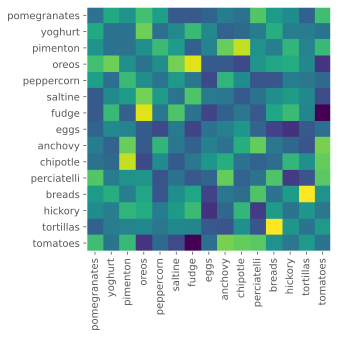

In [71]:
# adapted from https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html

fig, ax = plt.subplots()
im = ax.imshow(small_sims)

ax.set_xticks(np.arange(len(small_vectors)))
ax.set_yticks(np.arange(len(small_vectors)))

ax.set_xticklabels(small_words)
ax.set_yticklabels(small_words)
ax.grid(False)

plt.setp(ax.get_xticklabels(), rotation=90)

fig.tight_layout()
plt.show()

## Part 6: Build and Visualize Interactive Network Graph
VIEW .html FILE TO SEE RESULT!

In [74]:
indices = np.argwhere(sims_mat > 0.65)

In [75]:
indices[0]

array([  4, 701])

In [79]:
sims_mat[4, 701]

0.70124155

In [77]:
indices.shape

(1162, 2)

In [80]:
G = nx.Graph()

for index in indices:
  G.add_edge(words[index[0]], words[index[1]], 
             weight=sims_mat[index[0], index[1]])

In [82]:
weight_values = nx.get_edge_attributes(G, "weight")


In [85]:
print(weight_values[('udon', 'ramen')])

0.75651443


In [90]:
# Implement Fruchterman-Reingold force-directed algorithm: 
positions = nx.spring_layout(G)

In [98]:
for food in ["udon", "ramen", "watermelon", "fajita", "taco"]:
  print(food, positions[food])


udon [-0.23447444 -0.47050637]
ramen [-0.26668262 -0.50654358]
watermelon [0.51272982 0.19421203]
fajita [-0.88145572 -0.11107299]
taco [-0.86996752 -0.12858586]


In [99]:
nx.set_node_attributes(G, name="position", values=positions)

In [100]:
searches = ["udan", "taco"]

In [101]:
edge_x = []
edge_y = []
weights = []
ave_x, ave_y = [], []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['position']
    x1, y1 = G.nodes[edge[1]]['position']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)
    ave_x.append(np.mean([x0, x1]))
    ave_y.append(np.mean([y0, y1]))
    weights.append(f'{edge[0]}, {edge[1]}: {weight_values[(edge[0], edge[1])]}')

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    opacity=0.7,
    line=dict(width=2, color='White'),
    hoverinfo='text',
    mode='lines')

edge_trace.text = weights


node_x = []
node_y = []
sizes = []
for node in G.nodes():
    x, y = G.nodes[node]['position']
    node_x.append(x)
    node_y.append(y)
    # if user has searched for word, make its node bigger
    if node in searches:
        sizes.append(50)
    else:
        sizes.append(15)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        line=dict(color='White'),
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Picnic',
        reversescale=False,
        color=[],
        opacity=0.9,
        size=sizes,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2
    )
)

invisible_similarity_trace = go.Scatter(
    x=ave_x, y=ave_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        color=[],
        opacity=0,
    )
)

invisible_similarity_trace.text=weights

In [102]:
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append(adjacencies[0])

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

In [ ]:
fig = go.Figure(
    data=[edge_trace, node_trace, invisible_similarity_trace],
    layout=go.Layout(
        title='Network Graph of Word Embeddings',
        template='plotly_dark',
        titlefont_size=20,
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20,l=5,r=5,t=40),
        annotations=[
            dict(
                text="Adapted from: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                showarrow=False,
                xref="paper", yref="paper",
                x=0.005, y=-0.002 ) 
        ],
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )
)

plot(fig)

Drawback of using cosine similarity: need to recompute cosine similarity matrix each time a new observation is added.


Potential next step:
Convert the plurals of ingredients to their singular form (ex. "eggs" -> "egg") in order to reduce the size of the dataset and improve accuracy.